In [18]:
import numpy as np

import networkx as nx
import matplotlib.pyplot as plt

import os.path as op
import sys
sys.path.append("../")

from src import regmod
from src import utils
from src import solver
from src import regmod_torch

from tqdm import tqdm
import importlib

## Evaluation of optimal alpha and delta

Contents:
- Grid search like
    - Alpha
    - Delta
- Joint optimization
    - Alpha
    - Both at same time

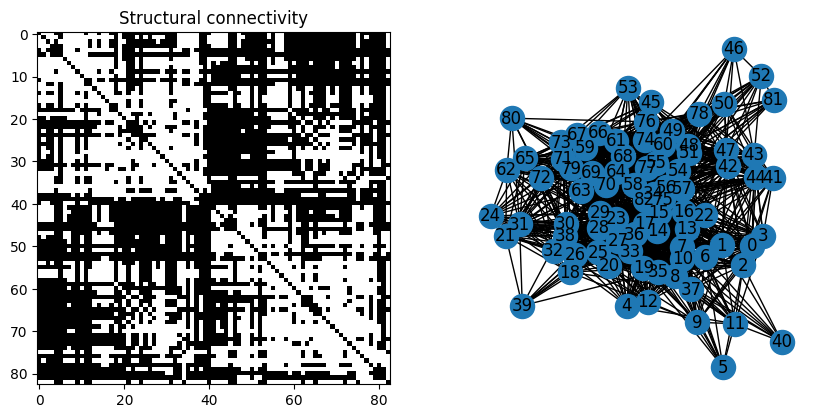

In [5]:
path_to_data = "../resources"

# Could be 50, 100, 200, 400
delay_max = 400
path_to_ftract = f"../../atlas_data/F-TRACT-090624/{delay_max}"

filename = "bundle_probability_atlas.pkl"

adj = utils.load(op.join(path_to_data, filename))

adj = adj[:83, :83]
adj -= np.diag(np.diag(adj))

bundle_prob_thresh = 0.9

adj = (adj > bundle_prob_thresh).copy().astype(int)

bundle_prob = utils.load(op.join(path_to_data, "bundle_probability_atlas.pkl"))
bundle_prob = bundle_prob[:83, :83]
bundle_prob -= np.diag(np.diag(bundle_prob))
ftract_prob = utils.load(op.join(path_to_data, "adj_probability_ftract.pkl"))
ftract_prob = ftract_prob[:83, :83]

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

axes[0].imshow(adj, cmap='gray')
axes[0].set_title('Structural connectivity')
toy_graph = nx.Graph(adj)
nx.draw(toy_graph, ax=axes[1], with_labels=True)

In [6]:
with open(op.join(path_to_ftract, 'peak_delay__median.txt')) as f:
    text = f.readlines()

y_ground_mat = []
for t in text[8:]:
    y_ground_mat.append(t.split(' '))
y_ground_mat = np.array(y_ground_mat).astype(float)
y_ground_mat = np.nan_to_num(y_ground_mat[:-1, :-1])

prob_thresh = 0
y_ground_mat *= ftract_prob > prob_thresh
y_ground = solver.torch.tensor(utils.remove_diagonal_entries(y_ground_mat).flatten())

In [13]:
import os
if os.path.exists(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl'):
    design_matrices_subopts = utils.load(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl')
else:
    design_matrices_subopts = []
    for k in tqdm(range(2)):
        design_matrices_subopts.append(regmod.get_shortest_matrices(adjacency=adj, n_subopt=k))

    utils.save(f'../resources/pre-compute_design-matrices/dmax{delay_max}-bthresh{bundle_prob_thresh}-fthresh{0}.pkl', design_matrices_subopts)

### Grid search like - Varying Alpha

In [13]:
max_path_depth = 1
alpha_space = np.linspace(0, 1, 10)

alphas_results = {}
for alpha in tqdm(alpha_space):
    design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
    design_model = solver.torch.tensor(design_shortest)

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=0,
                                            #early_stop=1e-10, step_size=5e-1,
                                            l2_penalty=1)
    
    alphas_results[alpha] = (x_opt,loss)

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:30<13:36, 90.70s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 20%|██        | 2/10 [03:01<12:07, 90.90s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 30%|███       | 3/10 [04:32<10:36, 90.92s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 40%|████      | 4/10 [06:04<09:08, 91.43s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 50%|█████     | 5/10 [07:30<07:27, 89.44s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 60%|██████    | 6/10 [09:16<06:19, 94.83s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 70%|███████   | 7/10 [35:47<29:12, 584.18s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 80%|████████  | 8/10 [37:15<14:12, 426.23s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 90%|█████████ | 9/10 [38:43<05:20, 320.37s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 10/10 [40:14<00:00, 241.41s/it]


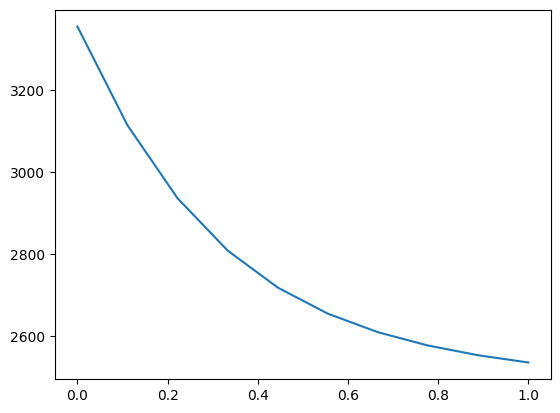

In [14]:
losses = [alphas_results[alpha][1] for alpha in alpha_space]
plt.plot(alpha_space, losses)

In [ ]:
# plot the mapping curve and see what it looks like

### Grid search like - Varying Delta

In [20]:
max_path_depth = 1

delta_space = np.linspace(0, 50, 11)
alpha = 0.8

design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
design_model = solver.torch.tensor(design_shortest)

delta_results = {}
for delta in tqdm(delta_space):

    # Define mapping area
    non_zero_mask = y_ground > 0
    y_masked = y_ground[non_zero_mask]
    design_model_masked = design_model[non_zero_mask]

    np.random.seed(99)
    x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)

    x = utils.deepcopy(x_init)
    x_opt, loss = solver.gradient_descent_solver(x, y_masked, design_model_masked,
                                            n_iter=10000, verbose=False, 
                                            early_stop=1e-10, step_size=5e-1, delta=delta,
                                            l2_penalty=1)
    
    delta_results[delta] = (x_opt,loss)

  0%|          | 0/11 [00:00<?, ?it/s]

  0%|          | 0/10000 [00:00<?, ?it/s]

  9%|▉         | 1/11 [01:25<14:16, 85.69s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 18%|█▊        | 2/11 [02:53<13:01, 86.84s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 27%|██▋       | 3/11 [04:17<11:23, 85.47s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 36%|███▋      | 4/11 [05:40<09:51, 84.45s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 45%|████▌     | 5/11 [07:06<08:31, 85.19s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 55%|█████▍    | 6/11 [08:31<07:05, 85.19s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 64%|██████▎   | 7/11 [09:58<05:42, 85.58s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 73%|███████▎  | 8/11 [11:22<04:15, 85.29s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 82%|████████▏ | 9/11 [12:48<02:51, 85.54s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

 91%|█████████ | 10/11 [14:16<01:26, 86.14s/it]

  0%|          | 0/10000 [00:00<?, ?it/s]

100%|██████████| 11/11 [15:43<00:00, 85.80s/it]


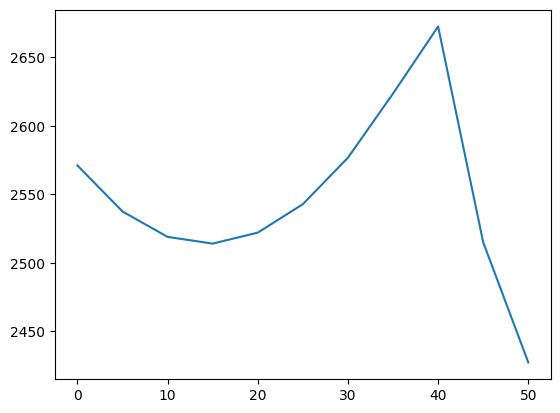

In [21]:
losses = [delta_results[delta][1] for delta in delta_space]
plt.plot(delta_space, losses)

### Joint Optimization - Alpha

In [90]:
importlib.reload(solver)
max_path_depth = 1

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
alpha_init = solver.torch.tensor(np.random.rand(1)).requires_grad_(True)

ldesign_model = solver.torch.tensor(design_matrices_subopts[max_path_depth])
# design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
# design_model = solver.torch.tensor(design_shortest)

# Define mapping area
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]

x = utils.deepcopy(x_init)
x_opt, a_opt, loss = solver.gradient_descent_solver_alpha(x, y_masked, ldesign_model, non_zero_mask, alpha_init, 
                                        n_iter=10000, verbose=False, 
                                        early_stop=1e-10, step_size=5e-1, delta=0,
                                        #early_stop=1e-10, step_size=5e-1,
                                        l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
utils.save('../resources/joint_optim_alpha.pkl', (x_opt,a_opt))

### Joint Optimization - Delta

In [85]:
importlib.reload(solver)

max_path_depth = 1

alpha = 0.8
design_shortest = regmod.apply_alpha_to_design(design_matrices_subopts[max_path_depth], n_subopt=max_path_depth, alpha=alpha)
design_model = solver.torch.tensor(design_shortest)

# Define mapping area
non_zero_mask = y_ground > 0
y_masked = y_ground[non_zero_mask]
design_model_masked = design_model[non_zero_mask]

np.random.seed(99)
x_init = solver.torch.tensor(np.random.rand(len(y_ground))).requires_grad_(True)
delta_init = (50 * solver.torch.tensor(np.random.rand(1))).requires_grad_(True)

x = utils.deepcopy(x_init)
delta = utils.deepcopy(delta_init)
x_opt, d_opt, loss = solver.gradient_descent_solver_delta(x, y_masked, design_model_masked, delta,
                                        n_iter=10000, verbose=False, 
                                        early_stop=1e-10, step_size=5e-1,
                                        l2_penalty=1)

  0%|          | 0/10000 [00:00<?, ?it/s]

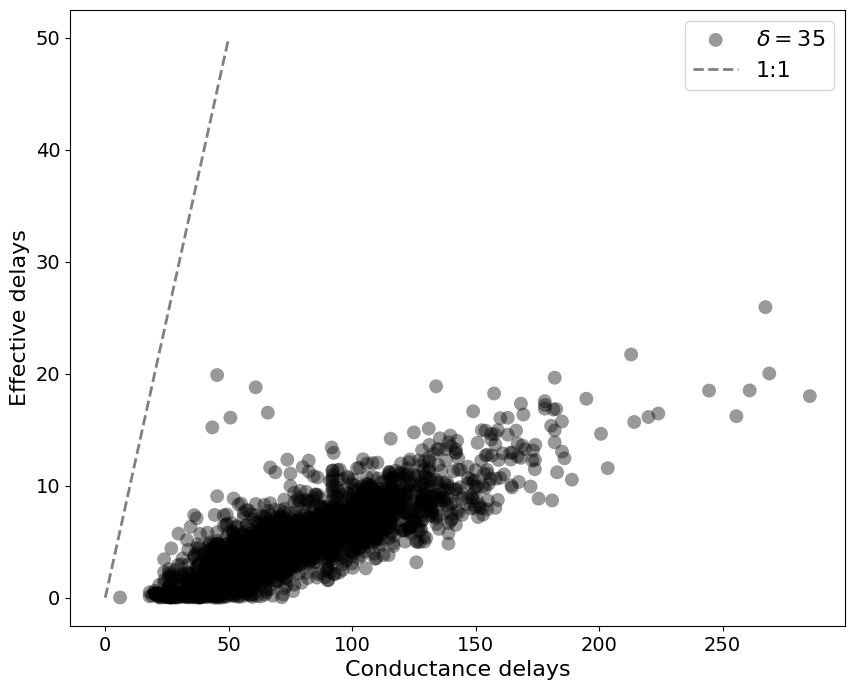

In [101]:
x = x_opt
y = y_ground

x_mask = x > 1e-5
y_mask = y != 0
xy_mask = np.logical_and(x_mask, y_mask).numpy().astype(bool)

fig, ax = plt.subplots(1,1, figsize=(10,8))

ax.scatter(y[xy_mask], x[xy_mask], s=100, alpha=.4, edgecolors="none", color='k', label=rf'$\delta={int(np.round(d_opt,0))}$')
# ax.scatter(y[~y_mask], x[~y_mask], s=100, alpha=.4, color="tab:brown", edgecolors="none")
# ax.scatter(y[~x_mask], x[~x_mask], s=100, alpha=.4, color="tab:purple", edgecolors="none")
ax.plot(np.linspace(0,50), np.linspace(0,50), linestyle='--', color="gray", linewidth=2, label="1:1")

ax.set_xlabel("Conductance delays", fontsize=16)
ax.set_ylabel("Effective delays", fontsize=16)
ax.tick_params(labelsize=14)

# ax.legend(["Non-zero", "Zero effective delays", "Zero conductance delays"], fontsize=16)
ax.legend(fontsize=16)

# if save_plots:
#     fig.savefig("../figures/scatter-effective_conductance.png", dpi=300)

In [88]:
# utils.save('../resources/joint_optim_delta.pkl', (x_opt,d_opt))